# Reddit Analysis - ML

The goal of this ML assignment is to do topic modeling to check which topic do the comemnts belong to and predict socre and awards associated with them.

## Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

In [3]:
# Starting spark session
spark = SparkSession.builder \
        .appName("RedditML") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.2") \
    .master('yarn') \
    .getOrCreate()

Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0104c778-5a9b-49e4-974d-20e54712b3ae;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found

In [4]:
spark

In [5]:
!/mnt/miniconda/bin/pip install sparknlp
!/mnt/miniconda/bin/pip install altair
!/mnt/miniconda/bin/pip install imageio
!/mnt/miniconda/bin/pip install collections
!/mnt/miniconda/bin/pip install wordcloud

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [6]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [7]:
import altair as alt

## Basic Data Checks

In [9]:
reddit_eda = spark.read.parquet('s3://aa2464-labdata2/reddit-eda')

In [8]:
reddit_sentiment = spark.read.parquet('s3://aa2464-labdata2/reddit-sentiment2/')

In [9]:
reddit_sentiment.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)



In [11]:
reddit_eda.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- associated_award: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_text_color: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitt

In [12]:
reddit_sentiment.count()

7373839

### Business Goal 1 : Which topic do the comments belong to?

Technical : We will run 2 models to achieve this. First is K means clustering which will be used to determine the optimal number of clusters using the Elbow method. USing this number w e welill cluster our comemnts using LDA

#### K Means Clustering

##### Building Pipeline for prep

In [10]:
from sparknlp.base import DocumentAssembler,Finisher
from sparknlp.annotator import Tokenizer,StopWordsCleaner
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer

In [11]:
documentAssembler = DocumentAssembler()\
    .setInputCol("document")\
    .setOutputCol("document2")

In [12]:
# Tokenizer to break words
tokenizer = Tokenizer() \
     .setInputCols(['document2']) \
     .setOutputCol('token')

In [16]:
def get_stopwords_list(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return list(frozenset(stop_set))

In [17]:
stopwords_path = "data_extra/english_stopwords.txt"
stopwords = get_stopwords_list(stopwords_path)

In [18]:
stopwords_custom1 = ['abc']

In [19]:
# Remove Stopwords
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['token']) \
     .setOutputCol('clean_token') \
     .setStopWords(stopwords)

In [20]:
finisher = Finisher() \
    .setInputCols(["clean_token"]) \
    .setOutputCols(["final"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

Fitting the pipeline on empty data frame

In [21]:
pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           stopwords_cleaner,
           finisher
     ])

In [22]:
empty_df = spark.createDataFrame([['']]).toDF("document")
pipelineModel = pipeline.fit(empty_df)

In [23]:
vectorised_reddit_comments = pipelineModel.transform(reddit_sentiment)

In [24]:
vectorised_reddit_comments.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)
 |-- document2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (null

In [25]:
cleaned_reddit_comments = vectorised_reddit_comments.withColumn("text", F.concat_ws(" ", "final"))

In [26]:
lem_comments = cleaned_reddit_comments.select(cleaned_reddit_comments.final)

In [27]:
important_words = lem_comments.withColumn('final', F.explode(col('final')))

In [28]:
count_words = important_words.groupby('final').count().sort('count', ascending=False)

In [29]:
count_words.show(10)

+--------+-------+
|   final|  count|
+--------+-------+
|  people|1352441|
|question| 798711|
|    time| 698895|
|    feel| 452123|
|     lot| 415667|
|     day| 314317|
|    life| 291745|
|  person| 276022|
|  reason| 274265|
|     bad| 270173|
+--------+-------+
only showing top 10 rows



In [30]:
count_words2 = count_words.limit(1000)

In [31]:
count_words2_df = count_words2.toPandas()

In [32]:
count_words2_df

,final,count
0,people,1352441
1,question,798711
2,time,698895
3,feel,452123
4,lot,415667
...,...,...
995,politician,16961
996,imply,16949
997,minor,16940
998,meme,16890


In [29]:
mask = imread('plots/images/reddit_logo.png')

In [33]:
text = " ".join(i for i in count_words2_df.final)
wc = WordCloud(
    max_words=1000,
    background_color='#E7E6E1').generate(text)

NameError: name 'WordCloud' is not defined

In [34]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(16)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig('plots/eda/most-words-wordcloud.png', bbox_inches='tight')

NameError: name 'plt' is not defined

In [35]:
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="final", outputCol="features", vocabSize=500, minDF=3.0)
# train the model
cv_model = cv.fit(vectorised_reddit_comments)
# transform the data. Output column name will be features.
vectorized_tokens = cv_model.transform(vectorised_reddit_comments)

In [36]:
vectorized_tokens.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)
 |-- document2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (null

In [37]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [ ]:
# Running a loop to find optimal number of clusters
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(100).setFeaturesCol('features')
    model = kmeans.fit(vectorized_tokens)
    cost[k] = model.summary.trainingCost
    

22/05/04 00:01:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/04 00:01:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [135]:
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)
df_cost.to_csv('data_extra/clustering_cost.csv',index = False)

In [43]:
df_cost = pd.read_csv('data_extra/clustering_cost.csv')

In [44]:
df_cost

,cluster,cost
0,2,1.097887e+08
1,3,1.053069e+08
2,4,1.038906e+08
3,5,1.030784e+08
4,6,1.024634e+08
5,7,1.015963e+08
6,8,1.012754e+08
7,9,1.009122e+08


In [45]:
df_cost['cost_normal'] = df_cost['cost']/100000000
df_cost['cost_normal']

0    1.097887
1    1.053069
2    1.038906
3    1.030784
4    1.024634
5    1.015963
6    1.012754
7    1.009122
Name: cost_normal, dtype: float64

In [46]:
df_cost['text_x'] = 4
df_cost['text_y'] = 1.07

elbow_plot = (
        alt.Chart(df_cost)
        .mark_line()
        .encode(
            x = alt.X("cluster", title="Number of Clusters"),
            y=alt.Y("cost_normal", title="Score",scale = alt.Scale(domain=[1,1.15])
                   ),
            color=alt.value('#fc9272'),
            tooltip=[alt.Tooltip('cost_normal')]
        )
    ).properties(width=600,title={
      "text": ["What is the optimal number of clusters?"], 
      "subtitle": ["Elbow Method - Topic Modelling"]
    },).interactive()

elbow_plot_point = (
        alt.Chart(df_cost)
        .mark_point()
        .encode(
            x = alt.X("cluster", title="Number of Clusters",scale = alt.Scale(domain=[1.9,9.5])),
            y=alt.Y("cost_normal", title="Score",scale = alt.Scale(domain=[1,1.15])
                   ),
            color=alt.value('#fc9272'),
            tooltip=[alt.Tooltip('cost_normal')]
        )
    ).properties(width=600,title={
      "text": ["What is the optimal number of clusters?"], 
      "subtitle": ["Elbow Method - Topic Modelling"]
    },).interactive()


text = alt.Chart(df_cost).mark_text(opacity = 0.1,size =20,
    text='Elbow at k = 3', angle=0
).encode(
    x='text_x', y='text_y'
)

elbow_plot = alt.layer(
    elbow_plot,elbow_plot_point,text#,rect,rect2,text2,text
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

elbow_plot.save("plots/elbow_plot.html")
elbow_plot

alt.LayerChart(...)

Making the model with k = 3

In [31]:
# Trains a 4 k-means model.
kmeans = KMeans().setK(4).setSeed(100).setFeaturesCol('features')
model = kmeans.fit(vectorized_tokens)
# Make predictions
predictions = model.transform(vectorized_tokens)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
# Evaluate clustering.
cost = model.summary.trainingCost
#cost = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(cost))
# Shows the result.
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
print(center)

22/04/29 20:28:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/29 20:28:07 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Silhouette with squared euclidean distance = 0.5102599222082395
Within Set Sum of Squared Errors = 55916169.73063542
Cluster Centers: 
[1.67530499e-01 4.71509038e-02 1.21871499e+00 1.44044209e-01
 1.29565163e-01 1.58209250e-01 9.93278002e-02 7.01254851e-02
 5.26711609e-02 7.48898081e-02 4.01478530e-02 8.96828566e-02
 7.52697134e-02 9.66277587e-02 6.71792804e-02 5.35937882e-02
 6.33879803e-02 1.49132226e-02 8.18056358e-02 6.42776565e-02
 4.41698099e-02 3.74071073e-02 4.10394675e-02 4.38499917e-02
 7.04995755e-02 3.49435375e-02 3.23404107e-02 4.96493629e-02
 4.45380855e-02 3.76920363e-02 5.92458491e-02 6.58263522e-02
 5.33030443e-02 5.61096919e-02 4.19989223e-02 5.50959649e-02
 1.29555472e-02 5.62066065e-02 4.00044193e-02 3.52556026e-02
 3.98958749e-02 4.59103966e-02 4.53754279e-02 4.48734101e-02
 4.30746747e-02 3.52827387e-02 3.73295756e-02 3.19469373e-02
 4.47299765e-02 7.15229940e-03 4.15104726e-02 4.66159351e-03
 5.10914525e-02 1.97667071e-02 3.15844766e-02 3.34239162e-02
 2.78803996

In [32]:
# Trains a 3 k-means model.
kmeans = KMeans().setK(3).setSeed(100).setFeaturesCol('features')
model = kmeans.fit(vectorized_tokens)
# Make predictions
predictions = model.transform(vectorized_tokens)
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
# Evaluate clustering.
cost = model.summary.trainingCost
#cost = model.computeCost(dataset)
print("Within Set Sum of Squared Errors = " + str(cost))

Silhouette with squared euclidean distance = 0.7362034977520407
Within Set Sum of Squared Errors = 56660952.02521935


Silhoutte Score comes out to be 73.6% for K =3, which is not that bad. 0 here represents that the clusters could not be seprataed at all and 100% means that maximum separation. Given the type and amount of data, 74% seems like a great result.

In [33]:
predictions.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)
 |-- document2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (null

In [34]:
prediction_summary = predictions.groupBy("prediction","is_award").agg(\
                                                              F.count("prediction").alias('Count'))

In [35]:
prediction_summary_df = prediction_summary.toPandas()

In [36]:
prediction_summary_df

,prediction,is_award,Count
0,1,1,23
1,0,0,6927551
2,0,1,12540
3,1,0,125109
4,2,0,306951
5,2,1,1665


Saving Predictions of S3 bucket 

In [38]:
predictions.write.parquet("s3://aa2464-labdata2/predictions_clustering/")

In [37]:
model.write().save('s3://aa2464-labdata2/clustering_model')

#### LDA

In [39]:
from pyspark.ml.clustering import LDA
lda = LDA(k=3, maxIter=10)
model = lda.fit(vectorized_tokens)
ll = model.logLikelihood(vectorized_tokens)
lp = model.logPerplexity(vectorized_tokens)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

The lower bound on the log likelihood of the entire corpus: -234656330.5974096
The upper bound on perplexity: 5.909958750971146


In [40]:
# extract vocabulary from CountVectorizer
vocab = cv_model.vocabulary
topics = model.describeTopics()   
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

In [41]:
words_topic =  {'topic1': topics_words[0], 'topic2': topics_words[1], 'topic3': topics_words[2]}
words_topic_df = pd.DataFrame(data = words_topic)
words_topic_df

,topic1,topic2,topic3
0,question,time,people
1,answer,people,day
2,action,lot,person
3,feel,woman,life
4,people,feel,time
5,reason,pretty,live
6,remove,yeah,talk
7,perform,happen,money
8,pay,word,job
9,bot,bad,food


In [43]:
len(vocab)

500

In [63]:
vocab_dict = {'vocab': vocab}
vocab_df = pd.DataFrame(vocab_dict) 
vocab_df.to_csv('data/topics_vocab.csv',index = False)
words_topic_df.to_csv('data/words_topics.csv',index = False)

In [46]:
topics.show(6)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[1, 10, 17, 3, 0,...|[0.07827456922192...|
|    1|[2, 0, 4, 23, 3, ...|[0.02832096689602...|
|    2|[0, 5, 7, 6, 2, 1...|[0.05522007183642...|
+-----+--------------------+--------------------+



In [28]:
from imageio import imread

In [50]:
mask = imread('plots/reddit_logo.png')

In [31]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [64]:
freq = Counter(vocab)
wc = WordCloud(
    max_words=1000,
    mask=mask,
    background_color='#E7E6E1').fit_words(freq)

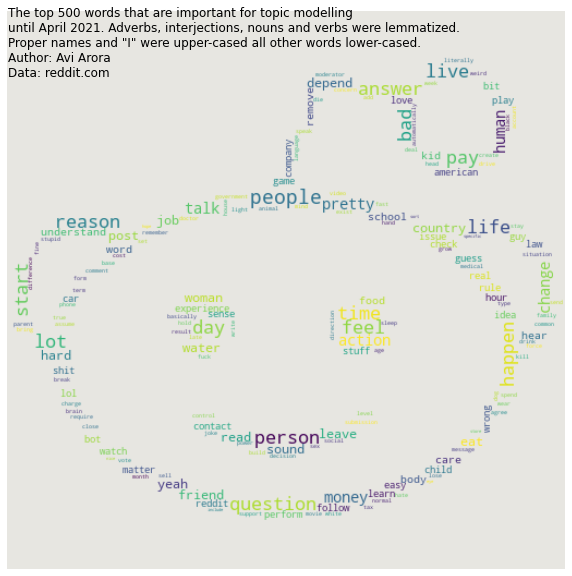

In [73]:
annotation = '''The top 500 words that are important for topic modelling
until April 2021. Adverbs, interjections, nouns and verbs were lemmatized.
Proper names and "I" were upper-cased all other words lower-cased.
Author: Avi Arora
Data: reddit.com'''

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(16)

plt.imshow(wc, interpolation='bilinear')
plt.annotate(annotation, xy=(0, 60), fontsize=12)
plt.axis('off')
plt.savefig('plots/reddit-topic-wordcloud.png', bbox_inches='tight')

## Business Question - 2

Predicting popularity of a comment

In [13]:
reddit_modeled = spark.read.parquet('s3://aa2464-labdata2/predictions_clustering/')

In [14]:
reddit_modeled.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)
 |-- document2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = true)
 |    |    |-- end: integer (nullable = true)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullab

In [75]:
## summary statistics of a column (numeric column)
reddit_modeled.select('score').describe().show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           7373839|
|   mean| 6.438911806997685|
| stddev|119.37104052051218|
|    min|              -629|
|    max|             26483|
+-------+------------------+



In [15]:
reddit_modeled.groupBy("sarcasm_class").agg(F.count("sarcasm_class").alias('Count')).show()

+-------------+-------+
|sarcasm_class|  Count|
+-------------+-------+
|         null|      0|
|      sarcasm| 715520|
|       normal|6584329|
+-------------+-------+



In [16]:
#Keeping the rows with only Sarcasm and Normal as sentiment
reddit_modeled = reddit_modeled.filter((reddit_modeled.sarcasm_class == 'sarcasm') | (reddit_modeled.sarcasm_class == 'normal'))

In [84]:
reddit_modeled.groupBy("emotion_class").agg(F.count("sarcasm_class").alias('Count')).show()

+-------------+-------+
|emotion_class|  Count|
+-------------+-------+
|          joy|1748782|
|         fear|3087079|
|      sadness|1148227|
|     surprise|1315761|
+-------------+-------+



In [17]:
#Keeping the rows with only Sarcasm and Normal as sentiment
reddit_modeled = reddit_modeled.filter((reddit_modeled.emotion_class == 'joy') | (reddit_modeled.emotion_class == 'fear') | (reddit_modeled.emotion_class == 'sadness') | (reddit_modeled.emotion_class == 'surprise'))



In [89]:
reddit_modeled.groupBy("sentiment_class").agg(F.count("sentiment_class").alias('Count')).show()

+---------------+-------+
|sentiment_class|  Count|
+---------------+-------+
|       positive|4737765|
|        neutral| 329456|
|       negative|2232628|
+---------------+-------+



In [18]:
#Keeping the rows with only Sarcasm and Normal as sentiment
reddit_modeled = reddit_modeled.filter((reddit_modeled.sentiment_class == 'negative') | (reddit_modeled.sentiment_class == 'neutral') | (reddit_modeled.sentiment_class == 'positive'))



#### Making target variable

In [19]:
# Checking 75th percentile
reddit_modeled.agg(F.expr('percentile(score, array(0.75))')[0].alias("75th")).show()

+----+
|75th|
+----+
| 3.0|
+----+



We define that every comment with a score of 3+ is a popular comment. This can also be seen as a classificaiton of comments that are liked more and the ones that are disliked more.

In [26]:
from pyspark.sql.functions import when
reddit_modeled = reddit_modeled.withColumn("is_popular", when(reddit_modeled.score >= 3,"Yes")\
                                 .when(reddit_modeled.score < 3,"No")\
                                 .otherwise("No"))

In [27]:
balance_target = reddit_modeled.groupBy("is_popular").agg(F.count("is_popular").alias('Count'))

In [28]:
balance_target_df = balance_target.toPandas()

In [29]:
balance_target_df

,is_popular,Count
0,Yes,1833549
1,No,5466300


In [30]:
balance_target_df['text_x'] = "Yes"
balance_target_df['text_y'] = 4000000

balance_plot = (
        alt.Chart(balance_target_df)
        .mark_bar()
        .encode(
            y = alt.X("Count", title="Count of comments"),
            x=alt.Y("is_popular", title="Is a Popular comment?"#,scale = alt.Scale(domain=[1,1.15])
                   ),
            color=alt.value('#fc9272'),
            tooltip=[alt.Tooltip('Count')]
        )
    ).properties(width=600,title={
      "text": ["What is the balance of target variable?"], 
      "subtitle": ["Count of comments for popular and not popular comments"]
    },).interactive()



text = alt.Chart(balance_target_df).mark_text(opacity = 1,size =13,
    text='Target Variable is imbalanced towards No', angle=0
).encode(
    x='text_x', y='text_y'
)

balance_plot = alt.layer(
    balance_plot,text#,elbow_plot_point,#,rect,rect2,text2,text
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
)

balance_plot.save("plots/ml/balance_plot.html")
balance_plot

alt.LayerChart(...)

We can see that our data is not balanced, so we will have to do downsampling to balance our dataset before moving on to our analysis.

#### Feature Engineering

In [31]:
import math

Cos and Sin have been taken of time variables to retain their cyclic nature

In [32]:
reddit_modeled = reddit_modeled.withColumn("hour_post", F.hour("created_date"))

In [33]:
reddit_modeled = reddit_modeled.withColumn("hour_cos",F.cos((2 * math.pi * reddit_modeled["hour_post"]) / 24))
reddit_modeled = reddit_modeled.withColumn("hour_sin",F.sin((2 * math.pi * reddit_modeled["hour_post"]) / 24))

In [34]:
reddit_modeled = reddit_modeled.withColumn("month_post", F.month("created_date"))

In [35]:
reddit_modeled = reddit_modeled.withColumn("month_cos",F.cos((2 * math.pi * reddit_modeled["month_post"]) / 12))
reddit_modeled = reddit_modeled.withColumn("month_sin",F.sin((2 * math.pi * reddit_modeled["month_post"]) / 12))

In [36]:
reddit_modeled = reddit_modeled.withColumn("year_post", F.year("created_date"))

In [37]:
reddit_modeled = reddit_modeled.withColumn("day_week", F.dayofweek("created_date"))

In [38]:
reddit_modeled = reddit_modeled.withColumn("day_week_cos",F.cos((2 * math.pi * reddit_modeled["day_week"]) / 7))
reddit_modeled = reddit_modeled.withColumn("day_week_sin",F.sin((2 * math.pi * reddit_modeled["day_week"]) / 7))

In [39]:
reddit_modeled = reddit_modeled.withColumn("day_month", F.dayofmonth("created_date"))

In [40]:
reddit_modeled = reddit_modeled.withColumn("day_month_cos",F.cos((2 * math.pi * reddit_modeled["day_month"]) / 31))
reddit_modeled = reddit_modeled.withColumn("day_month_sin",F.sin((2 * math.pi * reddit_modeled["day_month"]) / 31))

In [41]:
reddit_modeled.printSchema()

root
 |-- document: string (nullable = true)
 |-- sarcasm_class: string (nullable = true)
 |-- sarcasm_value: double (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- sentiment_value: double (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- Awards: string (nullable = true)
 |-- Jokes: string (nullable = true)
 |-- Covid: string (nullable = true)
 |-- created_date: string (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- reddit_age_post: integer (nullable = true)
 |-- is_award: integer (nullable = true)
 |-- document2: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = true)
 |    |    |-- end: integer (nullable = true)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullab

#### Balancing target variable

In [42]:
#Downsamping as controversiality is imbalanced
major_df = reddit_modeled.filter(F.col("is_popular") == "No")
minor_df = reddit_modeled.filter(F.col("is_popular") == "Yes")
ratio = int(major_df.count()/minor_df.count())

22/05/04 00:19:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [45]:
sampled_majority_df = major_df.sample(False, 1/3.2)
downsampled_df = sampled_majority_df.unionAll(minor_df)

In [46]:
downsampled_df.groupBy('is_popular').count().show()

+----------+-------+
|is_popular|  count|
+----------+-------+
|       Yes|1833549|
|        No|1707139|
+----------+-------+



In [47]:
downsampled_df2 = downsampled_df.select(['sarcasm_class', \
                                        'sentiment_class', \
                                        'emotion_class', \
                                        'gilded', \
                                        'controversiality',\
                                        'is_award',\
                                        'Jokes',\
                                        'Covid', \
                                        'is_weekend',\
                                        'reddit_age_post',\
                                        'prediction',\
                                       'is_popular',\
                                       'hour_cos',\
                                        'hour_sin',\
                                        'month_cos',\
                                        'month_sin',\
                                        'day_week_cos',\
                                        'day_week_sin',\
                                        'day_month_cos',\
                                        'day_month_sin',\
                                        'year_post',\
                                        ] )

In [48]:
null_values_s = downsampled_df2.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("boolean","timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in downsampled_df2.dtypes if c in downsampled_df2.columns
]).toPandas()

In [49]:
null_values = pd.melt(null_values_s)

In [50]:
null_values

,variable,value
0,sarcasm_class,0
1,sentiment_class,0
2,emotion_class,0
3,gilded,0
4,controversiality,0
5,is_award,0
6,Jokes,0
7,Covid,0
8,is_weekend,0
9,reddit_age_post,927493


We see that reddit age has a lot of null values, although it is very important variable, but so many nnull values will spoil our model. Thus we drop it

In [51]:
downsampled_df3 = downsampled_df2.drop("reddit_age_post")

In [52]:
downsampled_df3 = downsampled_df3.withColumn("is_joke", when(reddit_modeled.Jokes == "",0)\
                                 .otherwise(1))

In [53]:
downsampled_df3 = downsampled_df3.withColumn("is_covid", when(reddit_modeled.Covid == "",0)\
                                 .otherwise(1))

#### Feature Prep

In [54]:
downsampled_df3.groupBy("is_popular").agg(F.count("is_popular").alias('Count')).show()

+----------+-------+
|is_popular|  Count|
+----------+-------+
|       Yes|1833549|
|        No|1707139|
+----------+-------+



In [55]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC,DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [56]:
downsampled_df3 = downsampled_df3.drop("Jokes")
downsampled_df3 = downsampled_df3.drop("Covid")

In [57]:
downsampled_df3 = downsampled_df3.withColumnRenamed("prediction","topic")

In [58]:
downsampled_df3.printSchema()

root
 |-- sarcasm_class: string (nullable = true)
 |-- sentiment_class: string (nullable = true)
 |-- emotion_class: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- is_award: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- topic: integer (nullable = true)
 |-- is_popular: string (nullable = false)
 |-- hour_cos: double (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- day_week_cos: double (nullable = true)
 |-- day_week_sin: double (nullable = true)
 |-- day_month_cos: double (nullable = true)
 |-- day_month_sin: double (nullable = true)
 |-- year_post: integer (nullable = true)
 |-- is_joke: integer (nullable = false)
 |-- is_covid: integer (nullable = false)



In [59]:
#Splitting the data into train test and predict for our creating the model
train_data, test_data = downsampled_df3.randomSplit([0.8, 0.2], 2464)

In [60]:
train_data.groupBy("is_popular").agg(F.count("is_popular").alias('Count')).show()

+----------+-------+
|is_popular|  Count|
+----------+-------+
|       Yes|1467417|
|        No|1365966|
+----------+-------+



In [231]:
test_data.groupBy("is_popular").agg(F.count("is_popular").alias('Count')).show()

+----------+------+
|is_popular| Count|
+----------+------+
|       Yes|366132|
|        No|545326|
+----------+------+



In [61]:
##StringIndexer for fitting in our pipeline for all of the string data into indices 
stringIndexer_sarcasm_class = StringIndexer(inputCol="sarcasm_class", outputCol="sarcasm_class_idx")
stringIndexer_sentiment_class = StringIndexer(inputCol="sentiment_class", outputCol="sentiment_class_idx")
stringIndexer_emotion_class = StringIndexer(inputCol="emotion_class", outputCol="emotion_class_idx")
stringIndexer_popular = StringIndexer(inputCol="is_popular", outputCol="is_popular_idx")

In [62]:
##Hot encoding for categorical values having more tha 2 categories
onehot_sentiment = OneHotEncoder(inputCol="sentiment_class_idx", outputCol="sentiment_class_vec")
onehot_emotion = OneHotEncoder(inputCol="emotion_class_idx", outputCol="emotion_class_vec")

In [63]:
##Picking features for models
vectorAssembler_features = VectorAssembler(
    inputCols=["sarcasm_class_idx","sentiment_class_vec","emotion_class_vec",\
               "gilded","controversiality","is_award","is_weekend","topic",\
               "hour_cos","hour_sin","month_cos","month_sin","day_week_cos",\
               "day_week_sin","day_month_cos","day_month_sin","year_post","is_joke","is_covid"], 
    outputCol= "features")

#### Logistic Regression

In [64]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="is_popular_idx", featuresCol="features")

In [65]:
##Giving our predicted indices a label
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predicted_popularity", 
                               labels= ["Popular","Not Popular"])

In [66]:
#Creating a pipeline
pipeline_lr = Pipeline(stages=[stringIndexer_sarcasm_class, stringIndexer_sentiment_class,stringIndexer_emotion_class,stringIndexer_popular,\
                               onehot_sentiment,onehot_emotion,\
                               vectorAssembler_features, \
                               lr,labelConverter])

In [67]:
# Create ParamGrid for Hyper parameter tuning
lrparamGrid2 = ParamGridBuilder()\
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])\
             .addGrid(lr.elasticNetParam, [0.25, 0.5, 0.75])\
             .addGrid(lr.maxIter, [5, 10, 20])\
             .build()

In [68]:
# Evaluate model
lrevaluator2 = BinaryClassificationEvaluator().setLabelCol("is_popular_idx")

In [69]:
# Create 5-fold CrossValidator
lrcv2 = CrossValidator(estimator = pipeline_lr,
                    estimatorParamMaps = lrparamGrid2,
                    evaluator = lrevaluator2,
                    numFolds = 5)

In [70]:
# Run cross validations
lrcvModel2 = lrcv2.fit(train_data)

22/05/04 00:24:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/04 00:24:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/05/04 00:24:16 WARN BlockManager: Asked to remove block broadcast_68, which does not exist
22/05/04 00:36:19 WARN BlockManager: Asked to remove block broadcast_4124, which does not exist


In [72]:
# Save the model pipeline into s3
lrcvModel2.write().save('s3://aa2464-labdata2/lrcvModel3')

In [73]:
# Use test set here so we can measure the accuracy of our model on new data
lrprediction2 = lrcvModel2.transform(test_data)

In [74]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
lr_acc2 = lrevaluator2.evaluate(lrprediction2)

#Displaying the results
print("Accuracy = %g" % lr_acc2)
print("Test Error = %g" % (1.0 - lr_acc2))

Accuracy = 0.523832
Test Error = 0.476168


In [75]:
#Confusion Matrix 
#y_pred has the predicted labels
y_pred_lr=lrprediction2.select("prediction").collect()
#y_orig are the actual labels 
y_orig_lr =lrprediction2.select("is_popular_idx").collect()

In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
#Creating the confusion matrix 
cm = confusion_matrix(y_orig_lr, y_pred_lr)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[360755   5377]
 [333401   7772]]


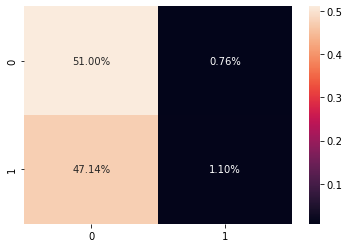

In [78]:
import seaborn as sns
cm_lm = sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%')

In [98]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema['features'].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema['features'].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [99]:
feature_importance_gbt=ExtractFeatureImp(lrcvModel2.bestModel.stages[-2].coefficients, lrprediction2, "features").head(10)




In [101]:
feature_importance_gbt

,idx,name,vals,score
1,7,controversiality,NaN,0.503633
15,21,is_covid,NaN,0.368393
5,11,hour_cos,NaN,0.029245
4,10,topic,NaN,0.011459
17,1,sentiment_class_vec_positive,NaN,0.007478
6,12,hour_sin,NaN,0.002945
13,19,year_post,NaN,0.000011
11,17,day_month_cos,NaN,0.000000
20,4,emotion_class_vec_joy,NaN,0.000000
14,20,is_joke,NaN,0.000000


In [104]:
def chart_imp_features(imp, model):
    categoryNames= list(imp.name)
    chart= alt.Chart(imp).mark_bar().encode(
       x=alt.X("name", title='Feature Name',sort=categoryNames),
       y=alt.Y("score", title='Importance Score')
       ).properties(
           title="Feature Importance in "+ model, 
           height=300, width=500
       )
    return chart

chart2_1= chart_imp_features(feature_importance_gbt,'Logistic Regression')
chart2_1=chart2_1.mark_bar(color='#B589D3')
chart2_1.save("plots/ml/fetaure_imp.html")
chart2_1

alt.Chart(...)

#### Decision Tree

In [79]:
dt = DecisionTreeClassifier(maxDepth=3, labelCol="is_popular_idx", leafCol="leafId")

In [80]:
#Creating a pipeline
pipeline_dt = Pipeline(stages=[stringIndexer_sarcasm_class, stringIndexer_sentiment_class,stringIndexer_emotion_class,stringIndexer_popular,\
                               onehot_sentiment,onehot_emotion,\
                               vectorAssembler_features, \
                               dt,labelConverter])

In [81]:
##Fitting the pipeline for train data
model_dt = pipeline_dt.fit(train_data)

In [82]:
##Transforming data for prediction
prediction_train_dt  = model_dt.transform(train_data)

In [83]:
##Predicting labels for test data
predictions = model_dt.transform(test_data)

In [84]:
##Evaluating accuracy and test error for test data
evaluatorDT = MulticlassClassificationEvaluator(labelCol="is_popular_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorDT.evaluate(predictions)

In [85]:
##Accuracy and Test Error for test_data 
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.530172
Test Error = 0.469828


In [86]:
##Creating a confusion matrix for our predictions
#y_pred has the predicted labels
y_pred=predictions.select("prediction").collect()
#y_orig are the actual labels 
y_orig=predictions.select("is_popular_idx").collect()

In [87]:
##Creating the confusion matrix 
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[364078   2054]
 [330258  10915]]


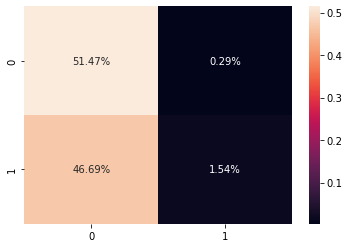

In [88]:
import seaborn as sns
cm_lm = sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%')

#### Random Forest

In [276]:
##intialising random forest classifier
rf = RandomForestClassifier(labelCol="is_popular_idx", featuresCol="features", numTrees=50)

In [277]:
#Creating a pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_sarcasm_class, stringIndexer_sentiment_class,stringIndexer_emotion_class,stringIndexer_popular,\
                               onehot_sentiment,onehot_emotion,\
                               vectorAssembler_features, \
                               rf,labelConverter])

In [278]:
##Fitting the pipeline for train data
model_rf = pipeline_rf.fit(train_data)

In [284]:
##Transforming data for prediction
prediction_train  = model_rf.transform(train_data)

In [287]:
##Predicting labels for test data
predictions = model_rf.transform(test_data)

In [288]:
##Evaluating accuracy and test error for test data
evaluatorRF = MulticlassClassificationEvaluator(labelCol="is_popular_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

In [289]:
##Accuracy and Test Error for test_data 
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.600448
Test Error = 0.399552


In [ ]:
##### Changing Parameters

In [290]:
##intialising random forest classifier
rf = RandomForestClassifier(labelCol="is_popular_idx", featuresCol="features", numTrees=100)

In [291]:
#Creating a pipeline
pipeline_rf = Pipeline(stages=[stringIndexer_sarcasm_class, stringIndexer_sentiment_class,stringIndexer_emotion_class,stringIndexer_popular,\
                               onehot_sentiment,onehot_emotion,\
                               vectorAssembler_features, \
                               rf,labelConverter])

In [292]:
##Fitting the pipeline for train data
model_rf = pipeline_rf.fit(train_data)

In [293]:
##Transforming data for prediction
prediction_train  = model_rf.transform(train_data)

In [294]:
##Predicting labels for test data
predictions = model_rf.transform(test_data)

In [295]:
##Evaluating accuracy and test error for test data
evaluatorRF = MulticlassClassificationEvaluator(labelCol="is_popular_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

In [296]:
##Accuracy and Test Error for test_data 
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.600451
Test Error = 0.399549


In [297]:
##Creating a confusion matrix for our predictions
#y_pred has the predicted labels
y_pred=predictions.select("prediction").collect()
#y_orig are the actual labels 
y_orig=predictions.select("is_popular_idx").collect()

In [298]:
##Creating the confusion matrix 
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[544973    353]
 [363819   2313]]


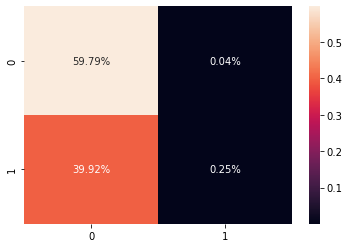

In [299]:
import seaborn as sns
cm_lm = sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%')